### Assignment Week 7
Travis James Smith

# Problem 2
This is mostly taken from the Apple stocks notebook, unsurprisingly. The changes are at the end. I trimmed it down as much as I could.

In [25]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  

In [26]:
import tensorflow as tf
from tensorflow.python.client import device_lib 

In [27]:
apple_training_complete = pd.read_csv(r'AAPL.csv')  

In [28]:
apple_training_processed = apple_training_complete.iloc[:, 1:2].values  

In [29]:
from sklearn.preprocessing import MinMaxScaler  
scaler = MinMaxScaler(feature_range = (0, 1))

apple_training_scaled = scaler.fit_transform(apple_training_processed)  


In [30]:
features_set = []  
labels = []  
for i in range(60, 1250):  
    features_set.append(apple_training_scaled[i-60:i, 0])
    labels.append(apple_training_scaled[i, 0])


In [31]:
features_set, labels = np.array(features_set), np.array(labels)  

In [32]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))  

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense  
from tensorflow.keras.layers import LSTM  
from tensorflow.keras.layers import Dropout  


In [34]:
model = Sequential()  
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1),unroll=False))  

In [35]:
model.add(Dropout(0.2))  

In [36]:
model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50))  
model.add(Dropout(0.2))  


In [37]:
model.add(Dense(units = 1))  

In [38]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')  

In [39]:
history = model.fit(features_set, labels, epochs = 100, batch_size = 32, verbose=0)  

In [40]:
from tensorflow.keras.models import load_model
model.save('apple.h5')
#model = load_model('apple.h5')
history_dict = history.history
history_dict.keys()

dict_keys(['loss'])

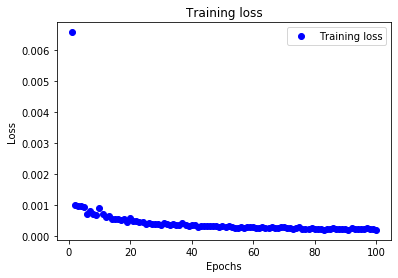

In [41]:
import matplotlib.pyplot as plt

loss = history.history['loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Predicting a week in advance
So now we want to predict a week in advance. We're using data from Yahoo finance between January and the end of March 2020, so we want to predict the open price for the first few days of April.


In [42]:
apple_testing_complete = pd.read_csv(r'AAPL_recent.csv')  
print(apple_testing_complete)
apple_testing_processed = apple_testing_complete.iloc[:, 1:2].values  
apple_testing_processed
print("Number of data points in March: ", apple_testing_processed.size)

          Date        Open        High         Low       Close   Adj Close  \
0   2019-12-02  267.269989  268.250000  263.450012  264.160004  263.534546   
1   2019-12-03  258.309998  259.529999  256.290009  259.450012  258.835724   
2   2019-12-04  261.070007  263.309998  260.679993  261.739990  261.120270   
3   2019-12-05  263.790009  265.890015  262.730011  265.579987  264.951172   
4   2019-12-06  267.480011  271.000000  267.299988  270.709991  270.069031   
..         ...         ...         ...         ...         ...         ...   
75  2020-03-20  247.179993  251.830002  228.000000  229.240005  229.240005   
76  2020-03-23  228.080002  228.500000  212.610001  224.369995  224.369995   
77  2020-03-24  236.360001  247.690002  234.300003  246.880005  246.880005   
78  2020-03-25  250.750000  258.250000  244.300003  245.520004  245.520004   
79  2020-03-26  246.520004  258.679993  246.360001  258.440002  258.440002   

       Volume  
0    23621800  
1    28607600  
2    16795400  

## Converting Test Data to Right Format


In [43]:
test_inputs = apple_testing_processed.reshape(-1,1)  
test_inputs = scaler.transform(test_inputs)  
print(test_inputs.shape)

(80, 1)


In [44]:
test_features = []  
for i in range(60, 80):  
    test_features.append(test_inputs[i-60:i, 0])

len(test_features)

20

In [45]:
test_features = np.array(test_features)  
print(test_features)

[[0.78660732 0.75333784 0.76358607 ... 0.91166509 0.85812193 0.83795975]
 [0.75333784 0.76358607 0.77368575 ... 0.85812193 0.83795975 0.74943912]
 [0.76358607 0.77368575 0.78738715 ... 0.83795975 0.74943912 0.8423412 ]
 ...
 [0.85177254 0.87516511 0.86900133 ... 0.71279064 0.71201086 0.64109041]
 [0.87516511 0.86900133 0.8707465  ... 0.71201086 0.64109041 0.671835  ]
 [0.86900133 0.8707465  0.89417624 ... 0.64109041 0.671835   0.72526671]]


## Making the predictions
So, to calculate five days in advance, we're just predicting each day in succession and prepending the previous prediction to the input array for the next prediction.


In [46]:
next_day_input = np.reshape(test_features[-1], (1, 60, 1))  

predictions = np.zeros(5)
for i in range(5):
    prediction = model.predict(next_day_input) 
    predictions[i] = prediction
    next_day_input = np.insert(next_day_input[:,0:59,:], 0, prediction, axis=1)
    
print(predictions)

[0.70515811 0.70287335 0.711164   0.71803677 0.7195282 ]


In [47]:
predictions = scaler.inverse_transform(np.reshape(predictions, (len(predictions), 1)))  
print(predictions)

[[245.33444002]
 [244.71911686]
 [246.95191869]
 [248.80286443]
 [249.20452926]]


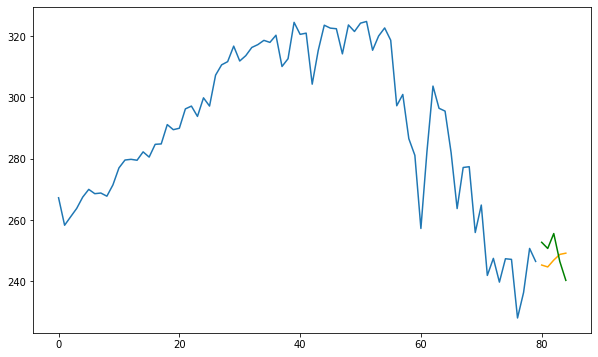

In [48]:
actual_prices = [252.75, 250.74, 255.60, 246.50, 240.34]

plt.figure(figsize=(10,6)) 
plt.plot(range(0, len(apple_testing_processed)), apple_testing_processed)
plt.plot(range(len(apple_testing_processed), len(apple_testing_processed)+5), predictions, color="orange")
plt.plot(range(len(apple_testing_processed), len(apple_testing_processed)+5), actual_prices, color="green")
plt.show()  


So, this actually looks pretty reasonable. But, when compared to the actual prices (in green, added manually), the model hasn't really done that well.